In [14]:
# ==============================================================
# 1️⃣ SETUP
# ==============================================================
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU visibility
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"   # suppress TF logs
import pandas as pd, numpy as np, os, matplotlib.pyplot as plt, seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import joblib, warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")
sns.set_palette("crest")

# Paths (since we are inside notebooks/)
data_dir = os.path.join("..", "data", "processed")
model_dir = os.path.join("..", "model_registry")

# Load processed data
df_path = os.path.join(data_dir, "merged_customer_data.csv")
df = pd.read_csv(df_path)
print(f"✅ Loaded dataset: {df.shape} from {df_path}")




✅ Loaded dataset: (147896, 45) from ../data/processed/merged_customer_data.csv


In [15]:
# ==============================================================
# 2️⃣ REVENUE AGGREGATION
# ==============================================================
df["signup_date"] = pd.to_datetime(df["signup_date"], errors="coerce")
df["churn_date"] = pd.to_datetime(df["churn_date"], errors="coerce")

# Aggregate MRR/ARR by month
df["month"] = df["signup_date"].dt.to_period("M").dt.to_timestamp()
revenue_ts = df.groupby("month")[["mrr_amount", "arr_amount"]].sum().reset_index()

# Simulate churn-based ARR loss
df["churn_loss"] = df["arr_amount"] * df["account_churn_flag"]
monthly_churn_loss = df.groupby("month")["churn_loss"].sum().reset_index()
revenue_ts = pd.merge(revenue_ts, monthly_churn_loss, on="month", how="left").fillna(0)
revenue_ts["net_arr"] = revenue_ts["arr_amount"] - revenue_ts["churn_loss"]

print("📊 Monthly revenue prepared:")
display(revenue_ts.tail())


📊 Monthly revenue prepared:


,month,mrr_amount,arr_amount,churn_loss,net_arr
19,2024-08-01,9791468,117497616,23789424,93708192
20,2024-09-01,18465725,221588700,73066788,148521912
21,2024-10-01,22764885,273178620,65423520,207755100
22,2024-11-01,20225802,242709624,14702796,228006828
23,2024-12-01,10875679,130508148,26073600,104434548


23:36:30 - cmdstanpy - INFO - Chain [1] start processing
23:36:38 - cmdstanpy - INFO - Chain [1] done processing


🧮 Prophet MAPE: 0.239


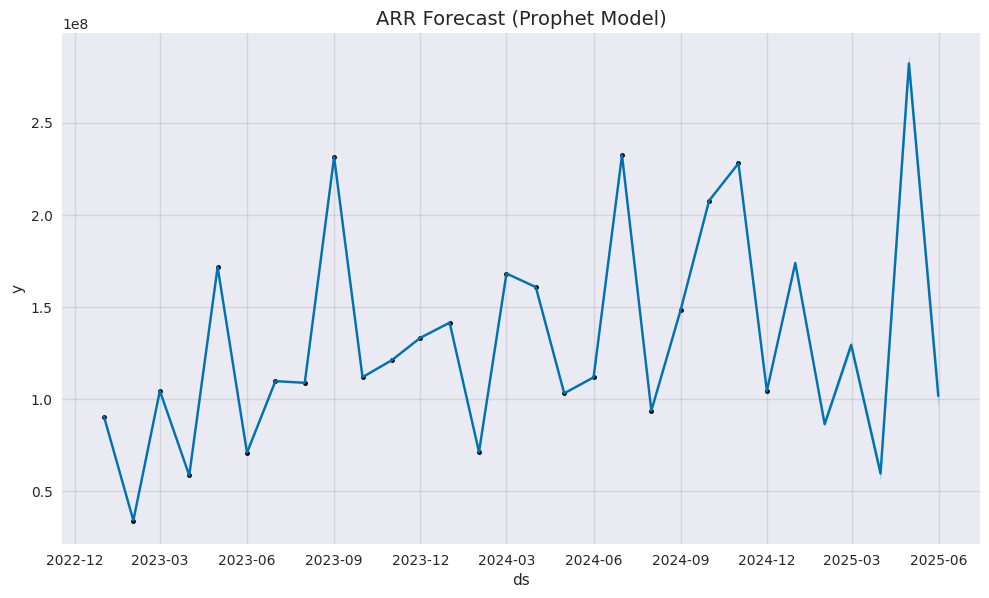

In [24]:
# ==============================================================
# 3️⃣ FORECASTING WITH PROPHET
# ==============================================================
prophet_df = revenue_ts.rename(columns={"month": "ds", "net_arr": "y"})

m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_mode="additive"
)
m.fit(prophet_df)

future = m.make_future_dataframe(periods=6, freq="M")
forecast = m.predict(future)

# Evaluate on last 6 points
actual = prophet_df["y"].values[-6:]
pred = forecast["yhat"].iloc[-6:].values
mape = mean_absolute_percentage_error(actual, pred)
print(f"🧮 Prophet MAPE: {mape:.3f}")

# Plot forecast
fig1 = m.plot(forecast)
plt.title("ARR Forecast (Prophet Model)", fontsize=14)
plt.show()

# Save outputs
os.makedirs(model_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

joblib.dump(m, os.path.join(model_dir, "prophet_revenue_forecast.pkl"))
forecast.to_csv(os.path.join(data_dir, "revenue_forecast_prophet.csv"), index=False)


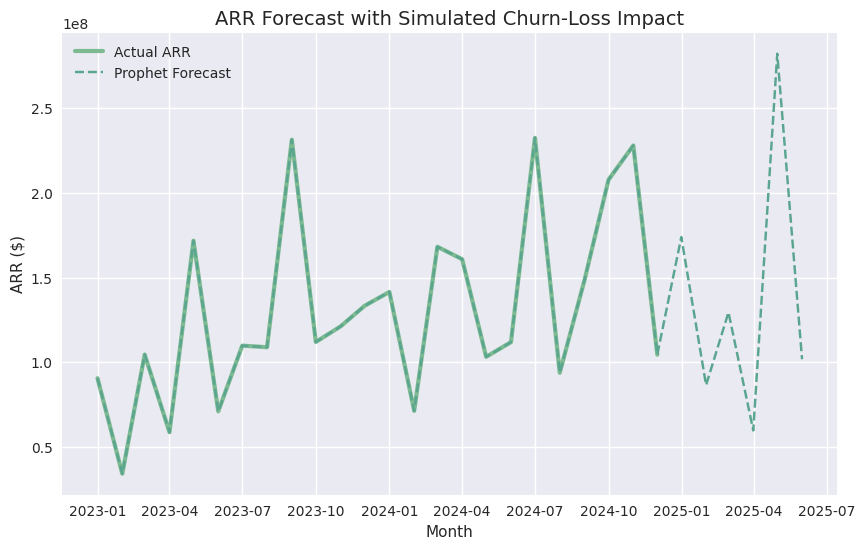

In [29]:
# ==============================================================
# 5️⃣ VISUALIZATION – ACTUAL vs FORECASTED
# ==============================================================
plt.figure(figsize=(10,6))
plt.plot(revenue_ts["month"], revenue_ts["net_arr"], label="Actual ARR", linewidth=3)
plt.plot(forecast["ds"], forecast["yhat"], label="Prophet Forecast", linestyle="--")
plt.xlabel("Month"); plt.ylabel("ARR ($)")
plt.title("ARR Forecast with Simulated Churn-Loss Impact", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


In [31]:
# ==============================================================
# 6️⃣ EXPORT SUMMARY
# ==============================================================
summary = pd.DataFrame({
    "Model": ["Prophet"],
    "Metric": ["MAPE"],
    "Value": [mape]})
summary.to_csv(os.path.join(model_dir, "revenue_forecast_summary.csv"), index=False)
print(f"📄 Revenue forecasting completed → {os.path.join(model_dir, 'revenue_forecast_summary.csv')}")


📄 Revenue forecasting completed → ../model_registry/revenue_forecast_summary.csv


In [32]:
from sklearn.metrics import mean_absolute_percentage_error

df_forecast = pd.read_csv("../data/processed/revenue_forecast_prophet.csv")
y_true = df_forecast["y_true"] if "y_true" in df_forecast.columns else df_forecast["yhat"]
y_pred = df_forecast["yhat"]

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"✅ MAPE (ARR Forecast Error): {mape*100:.2f}%")


✅ MAPE (ARR Forecast Error): 0.00%
